In [2]:
# !pip install pyarrow
!pip install ray
!pip install optuna
!pip install "ray[tune]" optuna


In [3]:
import pandas as pd
import numpy as np

import ray
from ray import tune, train
from ray.tune.search.optuna import OptunaSearch
import optuna
import os
import seaborn as sns
import matplotlib.pyplot as plt




In [14]:
def calculate_cylces_and_revenues(df_imb, battery_soc):
        # Custom function to apply the logic
    def calculate_revenues(row):
        if row['imbalance_charge'] > 0:
            # So if I consume more, I have a positive imbalance_charge
            # And if the price is positive, then I pay a little extra money, but that money is gone
            # If the price is negative, then I even make money by consuming more.
    
            take_price = 0
            if row['imbalance_regulation_state'] == 2:
                take_price = min(row['imbalance_take_price'], row['mid_price'])
            else:
                take_price = row['imbalance_take_price']
            return row['imbalance_charge'] * take_price
        else:
            # If price is > 0, but we feed in, then we get imbalance charge * feed price.
            # If price is < 0, but we feed in, then we get imbalance_charge * feed price, but we get money added
            # Oh no, if we feed in at a negative price, then money is simply taken away!
            # Because the country does not want energy. So for us that must mean that we pay a positive price (because negative was profit)
            feed_price = 0
            if row['imbalance_regulation_state'] == 2:
                feed_price = max(row['imbalance_feed_price'], row['mid_price'])
            else:
                feed_price = row['imbalance_feed_price']
            return np.abs(row['imbalance_charge']) * -feed_price

    cycles = df_imb['imbalance_charge'].abs().sum() / (2*battery_soc)

    df_imb['dates'] = pd.to_datetime(df_imb['dates'], format='%d-%m-%Y %H:%M:%S')
    df_imb.set_index('dates', inplace=True)

    # Resampling and applying different functions to different columns
    resampled_df = df_imb.resample('15T').agg({
        'imbalance_regulation_state': 'mean',  # Applying .mean() to the 'regulation_state' column
        'imbalance_charge': 'sum',
        'imbalance_take_price' : 'mean',
        'imbalance_feed_price' : 'mean',
        'mid_price' : 'mean',
    })

    # Applying the function to each row
    resampled_df['imbalance_income'] = resampled_df.apply(calculate_revenues, axis=1) / 1e6
    income = resampled_df['imbalance_income'].sum()

    return income, cycles

In [4]:
current_folder = globals()['_dh'][0]

df = pd.read_feather(os.path.join(current_folder, './backend/imbalance_data.feather'))
df_imb = pd.read_csv(os.path.join(current_folder, './backend/df_imb.csv'))

print(df_imb.head(1000))

     Unnamed: 0                dates     usage   max_price  min_price  \
0             0  01-01-2023 02:15:00  0.066667  157.814738  45.393026   
1             1  01-01-2023 02:16:00  0.066667  157.814738  45.393026   
2             2  01-01-2023 02:17:00  0.066667  157.814738  45.393026   
3             3  01-01-2023 02:18:00  0.066667   30.000000        NaN   
4             4  01-01-2023 02:19:00  0.066667   30.000000        NaN   
..          ...                  ...       ...         ...        ...   
995         995  01-01-2023 18:50:00  0.066667         NaN -52.540000   
996         996  01-01-2023 18:51:00  0.066667         NaN -52.540000   
997         997  01-01-2023 18:52:00  0.066667         NaN -52.540000   
998         998  01-01-2023 18:53:00  0.066667         NaN -52.540000   
999         999  01-01-2023 18:54:00  0.066667         NaN -52.540000   

     mid_price  imbalance_take_price  imbalance_feed_price  \
0     89.89552                 30.00                 30.00   

## Make the winter and the summer data

In [5]:
## Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

# Define the winter and summer periods
winter_start = pd.to_datetime('10/01', format='%m/%d').dayofyear
winter_end = pd.to_datetime('03/01', format='%m/%d').dayofyear

# Filter the DataFrame for winter and summer
df['DayOfYear'] = df['Date'].dt.dayofyear
df_winter = df[(df['DayOfYear'] >= winter_start) | (df['DayOfYear'] < winter_end)]
df_summer = df[(df['DayOfYear'] < winter_start) & (df['DayOfYear'] >= winter_end)]

# Calculate the standard deviation 'Consume' for each PTE for winter and summer
df_winter_std = df_winter.groupby('PTE')['Consume'].std().reset_index()
df_summer_std = df_summer.groupby('PTE')['Consume'].std().reset_index()

print(df_winter)
print(df_summer)


            Date  PTE period_from period_until upward_incident_reserve  \
0     2022-12-31    1       00:00        00:15                    None   
1     2022-12-31    2       00:15        00:30                    None   
2     2022-12-31    3       00:30        00:45                    None   
3     2022-12-31    4       00:45        01:00                    None   
4     2022-12-31    5       01:00        01:15                    None   
...          ...  ...         ...          ...                     ...   
35227 2024-01-01   92       22:45        23:00                    None   
35228 2024-01-01   93       23:00        23:15                    None   
35229 2024-01-01   94       23:15        23:30                    None   
35230 2024-01-01   95       23:30        23:45                    None   
35231 2024-01-01   96       23:45        00:00                    None   

      downward_incident_reserve  To regulate up  To regulate down  \
0                          None           

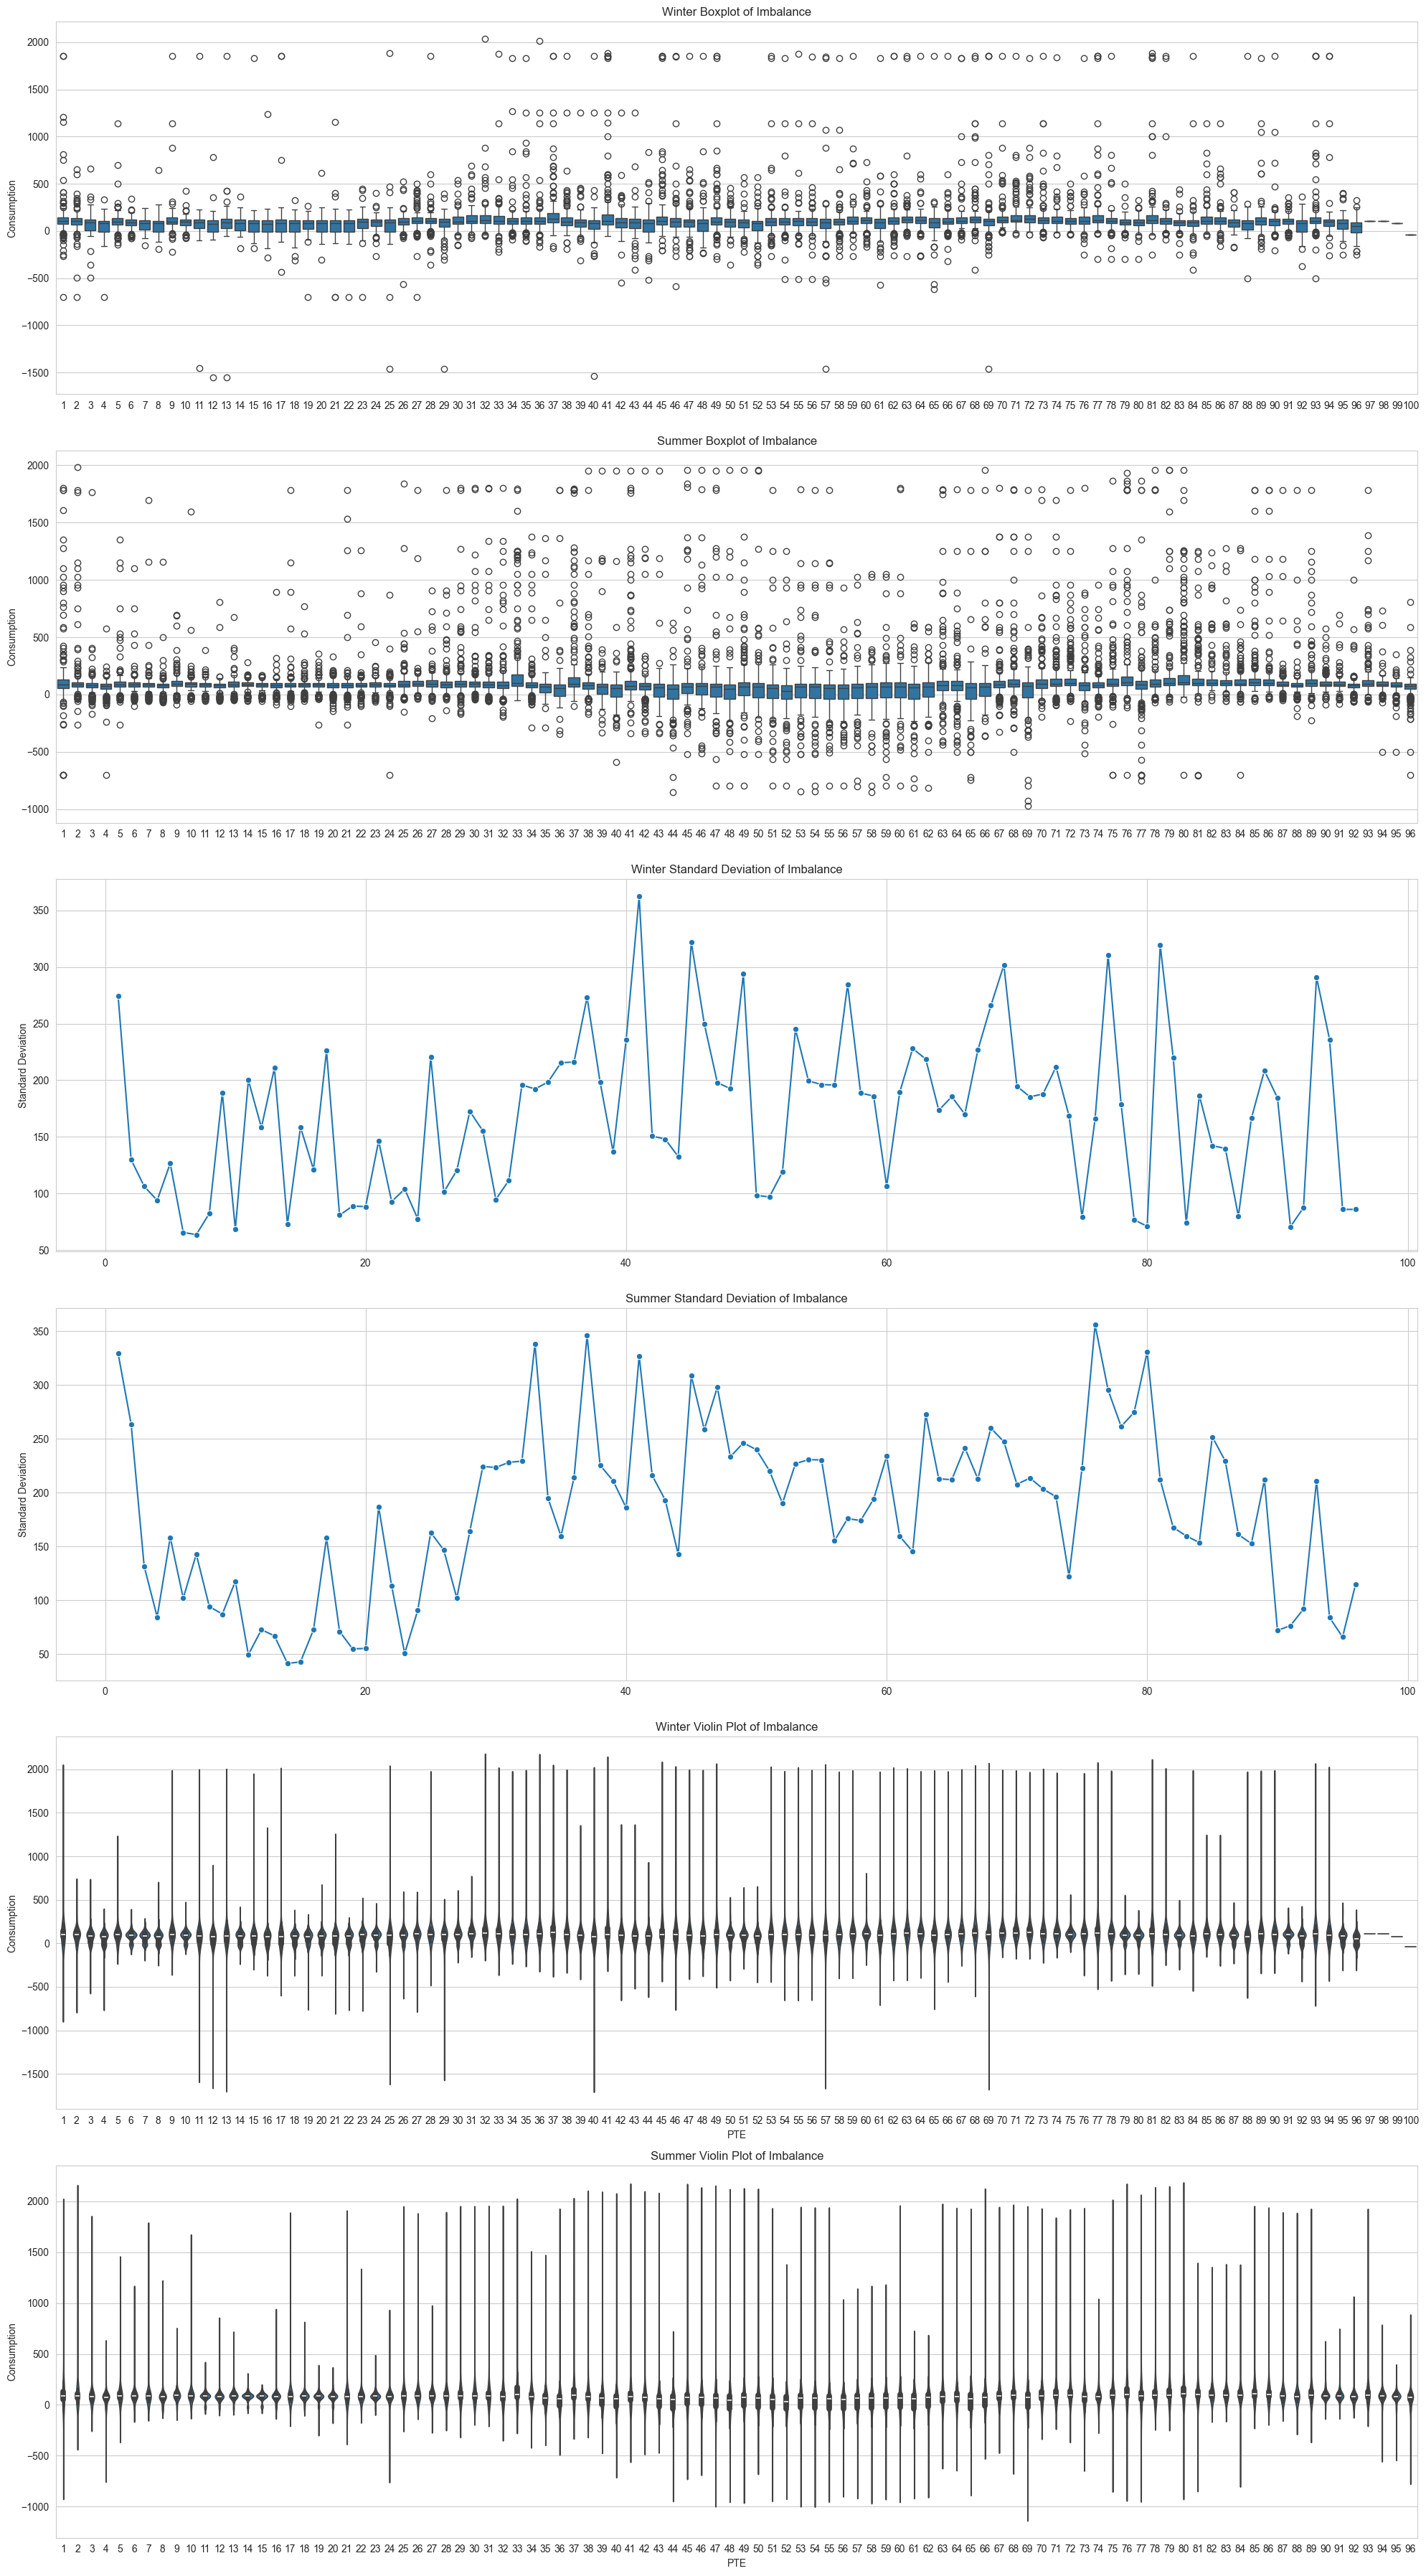

In [6]:
# Set the style of the visualization
sns.set_style("whitegrid")

# Calculate the standard deviation 'Consume' for each PTE for winter and summer
df_winter_std = df_winter.groupby('PTE')['Consume'].std().reset_index()
df_summer_std = df_summer.groupby('PTE')['Consume'].std().reset_index()

# Create a figure with 6 subplots (6 rows, 1 column)
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(20, 36))  # Adjust the figure size as needed

# Plot 1: Boxplot for winter
sns.boxplot(x='PTE', y='Consume', data=df_winter, ax=axes[0])
axes[0].set_title('Winter Boxplot of Imbalance')
axes[0].set_xlabel('')
axes[0].set_ylabel('Consumption')

# Plot 2: Boxplot for summer
sns.boxplot(x='PTE', y='Consume', data=df_summer, ax=axes[1])
axes[1].set_title('Summer Boxplot of Imbalance')
axes[1].set_xlabel('')
axes[1].set_ylabel('Consumption')

# Plot 3: Standard Deviation Plot for winter
sns.lineplot(x='PTE', y='Consume', data=df_winter_std, ax=axes[2], marker='o')
axes[2].set_title('Winter Standard Deviation of Imbalance')
axes[2].set_xlabel('')
axes[2].set_ylabel('Standard Deviation')

# Plot 4: Standard Deviation Plot for summer
sns.lineplot(x='PTE', y='Consume', data=df_summer_std, ax=axes[3], marker='o')
axes[3].set_title('Summer Standard Deviation of Imbalance')
axes[3].set_xlabel('')
axes[3].set_ylabel('Standard Deviation')

# Plot 5: Violin Plot for winter
sns.violinplot(x='PTE', y='Consume', data=df_winter, ax=axes[4])
axes[4].set_title('Winter Violin Plot of Imbalance')
axes[4].set_xlabel('PTE')
axes[4].set_ylabel('Consumption')

# Plot 6: Violin Plot for summer
sns.violinplot(x='PTE', y='Consume', data=df_summer, ax=axes[5])
axes[5].set_title('Summer Violin Plot of Imbalance')
axes[5].set_xlabel('PTE')
axes[5].set_ylabel('Consumption')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Based on this data, I would say that we should have a full SOC on PTE 24.
# Then there is quite some chance that we can charge cheapely somewhere from PTE 48 on.
# And then there is also a chance that we can sell for a lot in the evening around PTE 64 - 70

In [12]:
import pandas as pd

def opt_imbalance_wo_DA(df, charge_winter, discharge_winter, charge_summer, discharge_summer, charge_winter_night, discharge_winter_night, charge_summer_night, discharge_summer_night, battery_capacity, battery_charge_rate):
    df['dates'] = pd.to_datetime(df['dates'], format='%d-%m-%Y %H:%M:%S')
    df['DayOfYear'] = df['dates'].dt.dayofyear
    df['Hour'] = df['dates'].dt.hour

    # Define the winter and summer periods using dayofyear
    winter_start = pd.to_datetime('10/01', format='%m/%d').dayofyear
    winter_end = pd.to_datetime('03/01', format='%m/%d').dayofyear

    df['battery_soc'] = 0
    df['imbalance_charge'] = 0
    df['imbalance_income'] = 0

    # Init SOC to 50% of battery capacity as per the original setup
    initial_soc = battery_capacity / 2
    df['battery_soc'].iloc[0] = max(battery_capacity * 0.1, min(initial_soc, battery_capacity * 0.9))
    df_dict = df.to_dict('records')

    battery_soc = df['battery_soc'].iloc[0]
    charge_power = battery_charge_rate / 60  # Assuming charge_power is given in watts and charge_rate in watts per minute

    for i, row in enumerate(df_dict):
        # Determine if the date is in winter or summer
        if (row['DayOfYear'] >= winter_start) or (row['DayOfYear'] < winter_end):
            if 0 <= row['Hour'] < 6:
                imbalance_charge_factor = charge_winter_night
                imbalance_discharge_factor = discharge_winter_night
            else:
                imbalance_charge_factor = charge_winter
                imbalance_discharge_factor = discharge_winter
        else:
            if 0 <= row['Hour'] < 6:
                imbalance_charge_factor = charge_summer_night
                imbalance_discharge_factor = discharge_summer_night
            else:
                imbalance_charge_factor = charge_summer
                imbalance_discharge_factor = discharge_summer

        # Charging condition check
        if row['min_price'] is not None and row['min_price'] < imbalance_charge_factor:
            # Calculate the maximum SOC limit (90% of battery capacity)
            max_soc_limit = battery_capacity * 0.9
            # Calculate the remaining capacity for charging within the 90% limit
            remaining_capacity = max_soc_limit - battery_soc
            # Calculate the available energy to charge the battery, respecting the 90% limit
            available_energy = min(remaining_capacity, charge_power)
            # Update the battery state of charge
            battery_soc += available_energy

        # Discharging condition check
        if row['max_price'] is not None and row['max_price'] > imbalance_discharge_factor:
            # Calculate the minimum SOC limit (10% of battery capacity)
            min_soc_limit = battery_capacity * 0.1
            # Calculate the available energy for discharging within the 10% limit
            available_discharge_energy = battery_soc - min_soc_limit
            # Calculate the energy to discharge, respecting the 10% limit
            energy_to_discharge = min(available_discharge_energy, charge_power)
            # Update the battery state of charge
            battery_soc -= energy_to_discharge

        # Ensure that the battery state of charge is within the valid range [10%, 90%]
        battery_soc = max(battery_capacity * 0.1, min(battery_soc, battery_capacity * 0.9))

        df_dict[i]['battery_soc'] = battery_soc

        # Store the revenue made by charging and discharging
        if i > 0:
            df_dict[i]['imbalance_charge'] = df_dict[i]['battery_soc'] - df_dict[i-1]['battery_soc']

    df_result = pd.DataFrame(df_dict)

    # Assuming calculate_cylces_and_revenues is a function you have defined elsewhere
    income, cycles = calculate_cylces_and_revenues(df_result, battery_soc)

    # Define the cutoff for the amount of cycles you would like to habve
    if cycles > 350:
      income = 0

    print(income)
    print(cycles)

    return df_result, income, cycles


In [10]:
# Assuming opt_imbalance_wo_DA is already defined and adapted
# to work with a dictionary of parameters as input

ray.shutdown()

# Assuming df_imb is your large DataFrame
df_imb_ref = ray.put(df_imb)  # Store the DataFrame in the Ray object store

def tune_objective(config, df_ref):
    # Retrieve the DataFrame from the Ray object store inside the objective function
    df_imb = ray.get(df_ref)

    # Now call opt_imbalance_wo_DA with the DataFrame
    df_result, income, cycles = opt_imbalance_wo_DA(
        df=df_imb,  # Use the retrieved DataFrame
        charge_winter=config["charge_winter"],
        discharge_winter=config["discharge_winter"],
        charge_summer=config["charge_summer"],
        discharge_summer=config["discharge_summer"],
        charge_winter_night=config["charge_winter_night"],
        discharge_winter_night=config["discharge_winter_night"],
        charge_summer_night=config["charge_summer_night"],
        discharge_summer_night=config["discharge_summer_night"],
        battery_capacity=500e3,
        battery_charge_rate=125e3
    )

    # Report the negative income to maximize it through minimization, using the updated API
    tune.report(income=income)

# Define your search space for the parameters as before
search_space = {
    "charge_winter": tune.uniform(-100, 20),
    "discharge_winter": tune.uniform(50, 300),
    "charge_summer": tune.uniform(-100, 20),
    "discharge_summer": tune.uniform(50, 300),
    "charge_winter_night": tune.uniform(-100, 20),
    "discharge_winter_night": tune.uniform(20, 300),
    "charge_summer_night": tune.uniform(-100, 20),
    "discharge_summer_night": tune.uniform(20, 300),
}


# Configure Optuna for the search as before
optuna_search = OptunaSearch(metric="income", mode="max")

# Start the optimization
analysis = tune.run(
    lambda config: tune_objective(config, df_imb_ref),  # Pass the reference to the DataFrame
    config=search_space,
    num_samples=40,
    search_alg=optuna_search,
    resources_per_trial={"cpu": 1},
)

# Fetch the best parameters and their corresponding income
best_trial = analysis.best_trial
print("Best trial config:", best_trial.config)
print("Best trial income:", -best_trial.last_result["income"])

2024-04-29 09:22:28,040	INFO worker.py:1621 -- Started a local Ray instance.
2024-04-29 09:22:28,743	INFO tune.py:657 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
[I 2024-04-29 09:22:28,749] A new study created in memory with name: optuna


(<lambda> pid=32141) /var/folders/l5/_36585y53rx5n0tfqvgmb8nm0000gn/T/ipykernel_32094/1537314276.py:18: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
(<lambda> pid=32141) You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
(<lambda> pid=32141) A typical example is when you are setting values in a column of a DataFrame, like:
(<lambda> pid=32141) 
(<lambda> pid=32141) df["col"][row_indexer] = value
(<lambda> pid=32141) 
(<lambda> pid=32141) Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.
(<lambda> pid=32141) 
(<lambda> pid=32141) See the caveats in the documentation: https://pandas.pydata.org/p

(<lambda> pid=32141) imbalance_regulation_state       1.000000
(<lambda> pid=32141) imbalance_charge             -4166.666667
(<lambda> pid=32141) imbalance_take_price            30.000000
(<lambda> pid=32141) imbalance_feed_price            30.000000
(<lambda> pid=32141) Name: 2023-01-01 02:15:00, dtype: float64
(<lambda> pid=32141) imbalance_regulation_state     1.0
(<lambda> pid=32141) imbalance_charge               0.0
(<lambda> pid=32141) imbalance_take_price          30.0
(<lambda> pid=32141) imbalance_feed_price          30.0
(<lambda> pid=32141) Name: 2023-01-01 02:30:00, dtype: float64
(<lambda> pid=32141) imbalance_regulation_state    -1.00
(<lambda> pid=32141) imbalance_charge               0.00
(<lambda> pid=32141) imbalance_take_price         -10.46
(<lambda> pid=32141) imbalance_feed_price         -10.46
(<lambda> pid=32141) Name: 2023-01-01 02:45:00, dtype: float64
(<lambda> pid=32141) imbalance_regulation_state    -1.00
(<lambda> pid=32141) imbalance_charge             

2024-04-29 09:22:37,817	ERROR worker.py:405 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::ImplicitFunc.train() (pid=32143, ip=127.0.0.1, actor_id=52b66ec917a6d0a63f65fc2301000000, repr=<lambda>)
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'mid_price'

The above exception was the direct cause of the following exception:

ray::ImplicitFunc.train() (pid=32143, ip=127.0.0.1, actor_id=52b66ec917a6d0a63f65fc2301000000, repr=<lambda>)
  File "/Users/jacob/anaconda3/envs/tf-3.9/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 375, in train
    raise skipped from exception_cause(skipped)
  File "/Users/jacob/anaconda3/

ValueError: To fetch the `best_trial`, pass a `metric` and `mode` parameter to `tune.run()`. Alternatively, use the `get_best_trial(metric, mode)` method to set the metric and mode explicitly.

In [ ]:
# Benchmark case ==

_, income, cycles =  opt_imbalance_wo_DA(df_imb, -20, 150, -20, 150, -20, 150, -20, 150, 500e3, 125e3)
print(income)
print(cycles)


Best trial config: {'charge_winter': -14.783232243425344, 'discharge_winter': 54.465705741287394, 'charge_summer': 16.19267672872887, 'discharge_summer': 50.20564418513649, 'charge_winter_night': 19.830706694089418, 'discharge_winter_night': 20.185944997256925, 'charge_summer_night': 5.56931301624121, 'discharge_summer_night': 20.15069553603697}
Best trial income: 32024.616968749815

Normally at -5, 60 it is 29500 at 340 cycles